In [1]:
import torch
from PIL import Image
import cv2 
from torchvision import transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy

This code loads the checkpoint from the file checkpoint.pth, extracts the loss_dict from the checkpoint, and then plots the training and validation losses using Seaborn's lineplot function.

In [ ]:
checkpoint = torch.load('checkpoint.pth')
loss_dict = checkpoint['loss_dict']

model = checkpoint.get('ḿodel')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---
Resolviendo algunos errores en versiones futuras.

Opción 1: Usar weights_only=False

Si confías en la fuente del archivo de checkpoint (checkpoint.pth), puedes desactivar la carga segura estableciendo weights_only=False en torch.load. Esto permitirá cargar el archivo sin restricciones, pero ten en cuenta que podría ejecutar código arbitrario si el archivo no es de confianza.

In [3]:
checkpoint = torch.load('checkpoint.pth', weights_only=False)
loss_dict = checkpoint['loss_dict']

model = checkpoint.get('ḿodel')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Opción 2: Permitir el global de NumPy manualmente

Si prefieres mantener la carga segura (weights_only=True), puedes permitir explícitamente el global de NumPy que está causando el error (numpy.core.multiarray.scalar) usando torch.serialization.add_safe_globals.

In [ ]:
import torch
import numpy as np

# Permitir el global de NumPy
torch.serialization.add_safe_globals([np.core.multiarray.scalar])

# Cargar el checkpoint
checkpoint = torch.load('checkpoint.pth', weights_only=True)
loss_dict = checkpoint['loss_dict']

Opción 3: Actualizar el archivo de checkpoint

Si tienes control sobre cómo se guardó el archivo de checkpoint, puedes volver a guardarlo usando una versión más reciente de PyTorch que sea compatible con weights_only=True. Esto asegurará que el archivo se pueda cargar de manera segura en el futuro.

    Carga el archivo con weights_only=False (si es seguro hacerlo).

    Vuelve a guardar el archivo usando torch.save.

In [ ]:
# Cargar el checkpoint antiguo
checkpoint = torch.load('checkpoint.pth', weights_only=False)

# Guardar el checkpoint de nuevo
torch.save(checkpoint, 'checkpoint_new.pth')

Luego, puedes cargar el nuevo archivo (checkpoint_new.pth) con weights_only=True sin problemas.

Resumen

    Opción 1: Usa weights_only=False si confías en la fuente del archivo.
    Opción 2: Permite manualmente el global de NumPy usando add_safe_globals.
    Opción 3: Actualiza el archivo de checkpoint para que sea compatible con weights_only=True.

---

Este código define dos funciones:

1. loader(path): una función que carga una imagen desde una ruta de archivo usando la función Image.open() de PIL. Luego convierte la imagen en una matriz NumPy. Si la imagen está en escala de grises (es decir, tiene solo 2 dimensiones), la convierte a RGB usando la función cvtColor() de OpenCV.
2. valid_filepath(path): una función que verifica si la ruta de un archivo es válida verificando si la extensión del archivo es ".jpg". Si es así, la función devuelve Verdadero; de lo contrario, devuelve Falso.

In [4]:
def loader(path):
    img = Image.open(path)
    img = np.array(img)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

def valid_filepath(path):
    if path[-3:] == "jpg":
        return True
    else:
        return False

La clase Transform es un contenedor alrededor de la canalización de albumentaciones, lo que permite que se use como una función invocable. El método __call__ aplica la transformación a una imagen de entrada.

In [5]:
# train_transform = A.Compose([
#     A.HorizontalFlip(),
#     A.ShiftScaleRotate(rotate_limit=5, value=0, border_mode=cv2.BORDER_REFLECT),
#     A.OneOf([
#         A.CLAHE(),
#         A.RandomBrightnessContrast(),
#         A.HueSaturationValue()
#     ], p=1),
#     A.Normalize(),
#     A.Resize(600, 800),
#     ToTensorV2()
# ])

test_transform = A.Compose([
    A.Normalize(),
    A.Resize(600, 800),
    ToTensorV2()
])

class Transform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image):
        return self.transform(image=image)["image"]

Este código creará un gráfico de líneas con las curvas de pérdida de entrenamiento y pérdida de validación. El eje x representa el número de épocas y el eje y representa los valores de pérdida, la leyenda muestra las etiquetas de las curvas de pérdida de entrenamiento y de pérdida de validación.

In [ ]:
x = range(len(loss_dict['train_loss']))
sns.lineplot(x=x, y=loss_dict['train_loss'], label="Train Losses")
sns.lineplot(x=x, y=loss_dict['val_loss'], label="Validation Losses")
plt.title("Gráfico de pérdidas de conjuntos de datos de validación de entrenamiento")
plt.legend()

Este código crea un gráfico de líneas de las puntuaciones macro F1 de entrenamiento y validación utilizando la función de gráfico de líneas de Seaborn, el eje x representa el número de épocas y el eje y representa los valores de puntuación macro F1, la leyenda muestra las etiquetas de las puntuaciones de la macro F1 de entrenamiento y de la macro F1 de validación. <br>
El diccionario loss_dict contiene las puntuaciones macro F1 de entrenamiento y validación para cada época, que se trazan mediante la función lineplot.

In [ ]:
### Plot Training and Validation F1 Macro Scores
sns.lineplot(x=x,y=loss_dict['train_macro_f1'],label="Train F1 Macro");
sns.lineplot(x=x,y=loss_dict['val_macro_f1'],label="Validation F1 Macro");

### Set Plot Title and Legend
plt.title("Training Validation Datasets F1 Macro Plot");
plt.legend();

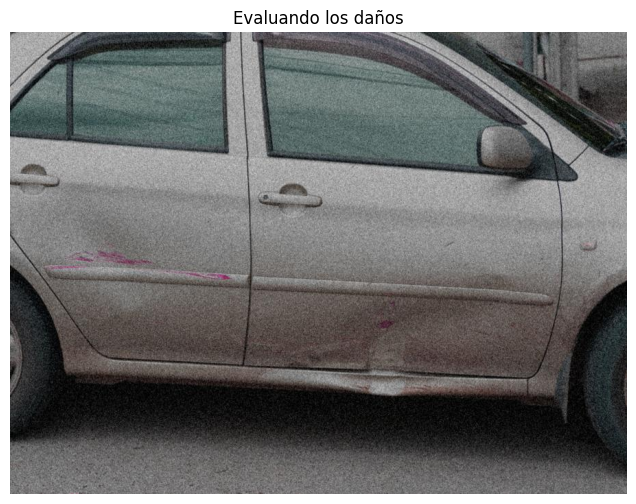

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
# ax = axes.flatten()

img = Image.open('predecir/7217.jpg')
img = np.array(img)
if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

plt.title("Evaluando los daños")
plt.axis("off")
plt.imshow(img)
plt.show()

In [13]:
data_dir = "predecir"
# test_transform = 
val_ds = ImageFolder(data_dir, transform=Transform(test_transform), loader=loader,
                     is_valid_file=valid_filepath)

---
El error FileNotFoundError: Couldn't find any class folder in predecir indica que el directorio predecir no contiene subcarpetas que representen las clases de tu conjunto de datos. La clase ImageFolder de PyTorch espera que el directorio raíz (data_dir) contenga subcarpetas, donde cada subcarpeta representa una clase y contiene las imágenes correspondientes a esa clase.
Posibles causas
    Estructura incorrecta del directorio:
        ImageFolder espera una estructura como esta:

predecir/
├── clase1/
│   ├── imagen1.jpg
│   ├── imagen2.jpg
│   └── ...
├── clase2/
│   ├── imagen1.jpg
│   ├── imagen2.jpg
│   └── ...
└── ...

        Si predecir no tiene subcarpetas, ImageFolder no puede encontrar las clases y lanza este error.

    Ruta incorrecta:

        Asegúrate de que la ruta predecir sea correcta y que el directorio exista en la ubicación especificada.

    Archivos sueltos en el directorio:

        Si tienes imágenes sueltas en predecir (sin subcarpetas), ImageFolder no podrá clasificarlas y lanzará este error.

Soluciones

Opción 1: Crear subcarpetas para las clases

Si tus imágenes no están organizadas en subcarpetas, puedes moverlas a subcarpetas según sus clases. Por ejemplo:

    Crea una subcarpeta llamada clase1 dentro de predecir y mueve todas las imágenes de esa clase allí.

    Repite el proceso para las demás clases.

Opción 2: Usar un dataset personalizado

Si no puedes o no quieres organizar las imágenes en subcarpetas, puedes crear un dataset personalizado que no dependa de la estructura de ImageFolder. Aquí tienes un ejemplo:

In [ ]:
# Verificar que NumPy esté disponible
try:
    import numpy as np
    print("NumPy está instalado y disponible.")
except ImportError:
    print("NumPy no está instalado. Instálalo con 'pip install numpy'.")

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_valid_file=None):
        self.root_dir = root_dir
        self.transform = transform
        self.is_valid_file = is_valid_file
        self.image_paths = self._get_image_paths()

    def _get_image_paths(self):
        image_paths = []
        for filename in os.listdir(self.root_dir):
            if self.is_valid_file(filename):
                image_paths.append(os.path.join(self.root_dir, filename))
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        img = np.array(img)
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        if self.transform:
            img = self.transform(image=img)["image"]
        return img

# Definir transformaciones
test_transform = A.Compose([
    A.Normalize(),
    A.Resize(600, 800),
    ToTensorV2()
])

# Crear el dataset
data_dir = "predecir"
val_ds = CustomDataset(data_dir, transform=test_transform, is_valid_file=valid_filepath)

# Verificar el dataset
print("Número de imágenes:", len(val_ds))
print("Primera imagen:", val_ds[0].shape)

Opción 3: Verificar la ruta del directorio

Asegúrate de que la ruta predecir sea correcta y que el directorio exista. Puedes verificar esto con

In [11]:
import os

data_dir = "predecir"
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"El directorio {data_dir} no existe.")

Resumen

    Opción 1: Organiza las imágenes en subcarpetas según sus clases.

    Opción 2: Usa un dataset personalizado si no puedes organizar las imágenes en subcarpetas.

    Opción 3: Verifica que la ruta del directorio sea correcta.
---

In [8]:
### Set Model to Evaluation Mode
# model.eval()

model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.eval()
y_pred = []

imgs = Image.open('predecir/7217.jpg')
output = model(imgs)
pred_labels = output.argmax(dim=1).tolist()
y_pred.extend(pred_labels)

# y_pred = []
# model.eval()
# with torch.no_grad():
#     for imgs in test_dl:
#         imgs = imgs.to(device)
#         output = model(imgs)
#         pred_labels = output.argmax(dim=1).tolist()
#         y_pred.extend(pred_labels)

TypeError: conv2d() received an invalid combination of arguments - got (JpegImageFile, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!JpegImageFile!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!JpegImageFile!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


In [ ]:
checkpoint = { 
    'loss_dict': loss_dict,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_sched': lr_scheduler}
torch.save(checkpoint, 'checkpoint.pth')